In [1]:
import warnings

import os
import shutil
import stat
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import Hyperband, HyperParameters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

warnings.filterwarnings('ignore')

In [2]:
train_directory = '../b. Datasets/Garbage Dataset/Train'
test_directory = '../b. Datasets/Garbage Dataset/Test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [4]:
train_data = train_datagen.flow_from_directory(directory=train_directory, 
                                               class_mode='categorical', 
                                               color_mode='rgb', 
                                               target_size=(80, 80), 
                                               batch_size=64, 
                                               seed=0)
test_data = test_datagen.flow_from_directory(directory=test_directory, 
                                             class_mode='categorical', 
                                             color_mode='rgb', 
                                             target_size=(80, 80), 
                                             batch_size=64,
                                             seed=0)

Found 960 images belonging to 8 classes.
Found 240 images belonging to 8 classes.


In [5]:
def get_CNN_model(hp):
    # Model building.
    model = Sequential()

    # Input layer
    model.add(Input(shape=(80, 80, 3)))

    # Convolutional layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU())

    ## 1x1 Convolutional layer to reduce computational cost
    model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))

    model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ## 1x1 Convolutional layer to reduce computational cost
    model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))

    model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ## 1x1 Convolutional layer to reduce feature map size
    model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))

    # Global average pooling - to convert to 1D.
    model.add(GlobalAveragePooling2D())

    # Dense layers
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    # Output layer.
    model.add(Dense(units=8, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=AdamW(
            learning_rate=hp.Choice('learning_rate', [0.005, 0.001]),
            weight_decay=hp.Choice('weight_decay', [1e-5, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Return model
    return model

In [6]:
hp = HyperParameters()
model = get_CNN_model(hp)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 80, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 80, 80, 32)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 32)          │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 40, 40, 32)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 32)          │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,496 (91.78 KB)

 Trainable params: 23,496 (91.78 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
folder_path = "hyperparam_tuning"

def remove_readonly(func, path, _):
    """Change file permissions and retry deletion."""
    os.chmod(path, stat.S_IWRITE)
    func(path)

if os.path.exists(folder_path):
    shutil.rmtree(folder_path, onerror=remove_readonly)

In [8]:
tuner = Hyperband(hypermodel=get_CNN_model, 
                  max_epochs=10, 
                  factor=5, 
                  seed=0, 
                  objective='val_accuracy', 
                  directory='hyperparam_tuning',
                  project_name='garbage_classification')

In [9]:
tuner.search(train_data, epochs=10, validation_data=test_data)

Trial 4 Complete [00h 00m 14s]
val_accuracy: 0.17083333432674408

Best val_accuracy So Far: 0.19583334028720856
Total elapsed time: 00h 00m 55s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = get_CNN_model(best_hps)

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
model_checkpoint = ModelCheckpoint(filepath='best_cnn_model.keras', 
                                   save_best_only=True,
                                   monitor='val_loss', 
                                   verbose=1)

In [12]:
total_epochs = 15
history = best_model.fit(train_data, 
                         epochs=total_epochs, 
                         validation_data=test_data, 
                         batch_size=64, 
                         callbacks=[model_checkpoint, 
                                    early_stopping])

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1139 - loss: 2.0796
Epoch 1: val_loss improved from inf to 2.07901, saving model to best_cnn_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.1143 - loss: 2.0797 - val_accuracy: 0.1250 - val_loss: 2.0790
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.1072 - loss: 2.0798
Epoch 2: val_loss improved from 2.07901 to 2.07754, saving model to best_cnn_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.1077 - loss: 2.0798 - val_accuracy: 0.1458 - val_loss: 2.0775
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.1618 - loss: 2.0758
Epoch 3: val_loss improved from 2.07754 to 2.07010, saving model to best_cnn_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.1607 - loss: 2.0758 - val_accuracy: 0.1625 - val_loss: 2.0701
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.1496 - loss: 2.0634
Epoch 4: val_loss improved from 2.07010 to

In [13]:
best_model = tf.keras.models.load_model('best_cnn_model.keras')

In [14]:
total_epochs = len(history.history['accuracy'])

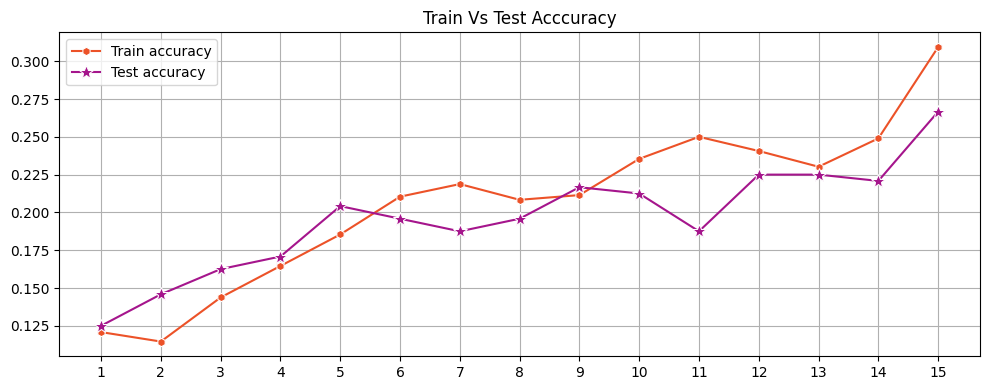

In [15]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['accuracy'], 
             label='Train accuracy', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_accuracy'], 
             label='Test accuracy', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Acccuracy")
plt.grid()
plt.tight_layout()
plt.show()

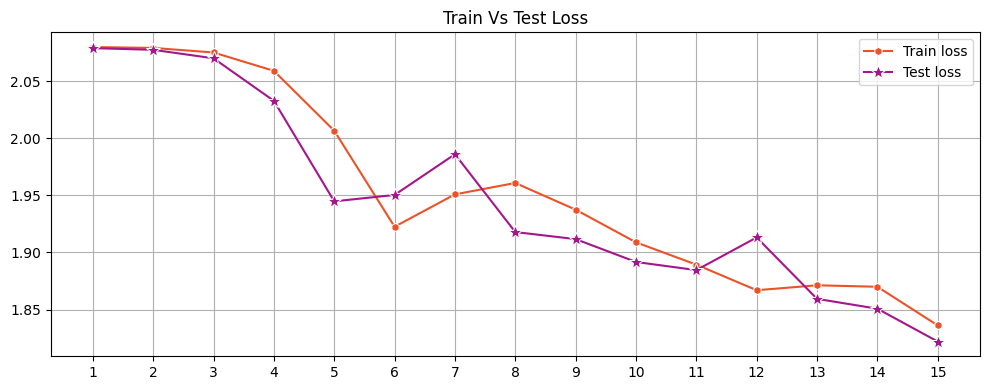

In [16]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['loss'], 
             label='Train loss', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_loss'], 
             label='Test loss', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
test_prediction = model.predict(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [18]:
test_prediction_class = np.argmax(test_prediction, axis=1)

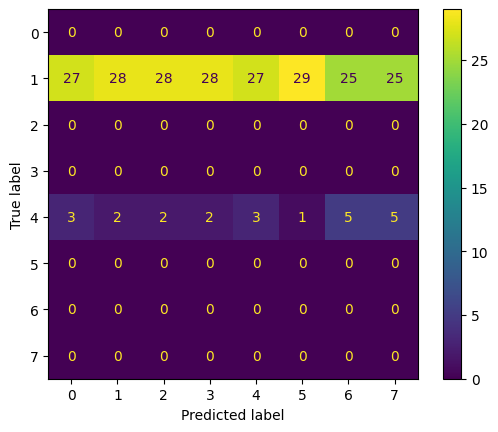

In [19]:
ConfusionMatrixDisplay(confusion_matrix(test_prediction_class, test_data.classes)).plot()

In [20]:
print(classification_report(test_prediction_class, test_data.classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.93      0.13      0.23       217
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.10      0.13      0.11        23
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.13       240
   macro avg       0.13      0.03      0.04       240
weighted avg       0.85      0.13      0.22       240



In [21]:
test_loss, test_accuracy = best_model.evaluate(test_data)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.2499 - loss: 1.7946
Test loss: 1.8219830989837646
Test accuracy: 0.2666666805744171


In [22]:
submission_df = pd.DataFrame({
    'FileName': test_data.filenames,
    'Class': test_prediction_class
}).sort_values(by='FileName', ascending=True)

In [23]:
display(submission_df.head(2))
display(submission_df.tail(2))

,FileName,Class
0,battery\battery121.jpg,1
1,battery\battery122.jpg,1


,FileName,Class
238,shoes\shoes149.jpg,1
239,shoes\shoes150.jpg,4


In [24]:
submission_df.to_csv("../c. Output Files/Image Classification - Garbage Data - CNN.csv", index=False)